# Data Preparation Workflow

This notebook demonstrates the data preparation workflow for the Snow Drought Index package. It covers loading data, preprocessing, station extraction and filtering, and data availability assessment.

In [2]:
# Install missing packages

#%pip install git+https://github.com/Nadiesenali/snowdroughtindex-main   # Install snowdroughtindex from the local source directory

# Import required packages
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import sys

# Import snowdroughtindex package
from snowdroughtindex.core import data_preparation
from snowdroughtindex.utils import visualization, io

First, we'll load the SWE data and other required datasets.

In [3]:
# Define data paths
canswe_path = r"C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CanSWE\CanSWE-CanEEN_1928-2024_v7.nc"
casr_swe = r"C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CASR_SWE\\"
casr_precipitation = r"C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CASR_Precipitation\\"
basin_path = r"C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\elevation\Bow_elevation_with_stats.shp"
output_data = r"C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\\"
output_plots = r"C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_plots\\"

In [6]:
# Load data using the implemented functions
canswe = data_preparation.load_swe_data(canswe_path)
bow_basin = data_preparation.load_basin_data(basin_path)

# Extract CanSWE data for stations within the Bow basin

In [ ]:
# Get station locations from canswe
stations_df = pd.DataFrame({
	'station_id': canswe['station_id'].values,
	'lat': canswe['lat'].values,
	'lon': canswe['lon'].values
})

# Create Point geometries for each station
stations_gdf = gpd.GeoDataFrame(
	stations_df,
	geometry=gpd.points_from_xy(stations_df['lon'], stations_df['lat']),
	crs=bow_basin.crs
)

# Find stations within any of the Bow basin polygons
stations_in_basin = stations_gdf[stations_gdf.within(bow_basin.unary_union)]

# Select these stations from canswe
bow_canswe = canswe.sel(station_id=stations_in_basin['station_id'].values)

# Convert to DataFrame
bow_canswe_df = bow_canswe.to_dataframe().reset_index()

# Save the extracted data to a CSV file
bow_canswe_df.to_csv(output_data + 'bow_canswe.csv', index=False)

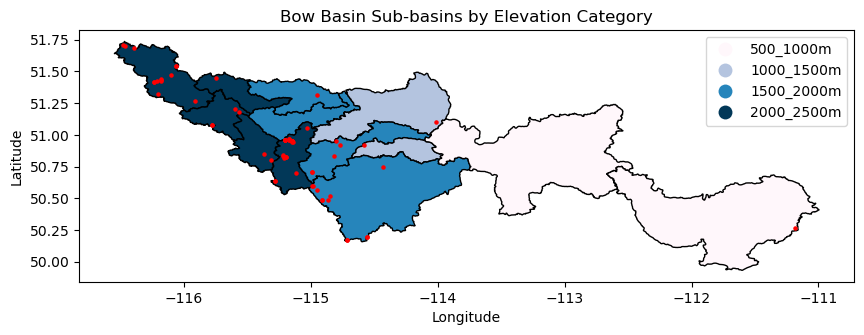

In [11]:
# Plot Bow basin polygons colored by elevation category
fig, ax = plt.subplots(figsize=(10, 10))

# Create elevation class column based on 'mean' elevation
bins = [500, 1000, 1500, 2000, 2500]
labels = ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m']
bow_basin['elev_class'] = pd.cut(bow_basin['mean'], bins=bins, labels=labels, include_lowest=True, right=False)

# Ensure elev_class is a categorical type with desired order
bow_basin['elev_class'] = pd.Categorical(
    bow_basin['elev_class'],
    categories=labels,
    ordered=True
)

bow_basin.plot(ax=ax, column='elev_class', cmap='PuBu', legend=True, edgecolor='black')
# Add station points
stations_in_basin.plot(ax=ax, color='red', markersize=5, label='Stations')
ax.set_title('Bow Basin Sub-basins by Elevation Category')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.savefig(output_plots + 'bow_basin_by_elev_class.png', dpi=300)
plt.show()

# Extract CaSR_v3.1 SWE and Preciptation data for the Bow river

In [7]:
#%pip install dask

import glob
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point

# Find all CaSR SWE NetCDF files matching the pattern
# (casr_swe and casr_swe_nc_files are already defined in previous cells)
# casr_swe_nc_files = glob.glob(casr_swe + "CaSR_v3.1_P_SWE_LAND_rlon*_rlat*_*.nc")

# Load all NetCDF files as a single xarray.Dataset
# (ds is already defined in previous cells)
# ds = xr.open_mfdataset(casr_swe_nc_files, combine='by_coords')

# Assume the dataset has 'lon' and 'lat' 2D coordinates
# (lons and lats are already defined in previous cells)
# lons = ds['lon'].values
# lats = ds['lat'].values

# Flatten the grid for spatial selection
lon_flat = lons.flatten()
lat_flat = lats.flatten()
points = gpd.GeoSeries([Point(lon, lat) for lon, lat in zip(lon_flat, lat_flat)], crs=bow_basin.crs)

# Find which grid points are inside the Bow basin
mask = points.within(bow_basin.unary_union)
selected_points_idx = mask[mask].index

# Get the indices in the original grid
import numpy as np
grid_shape = lons.shape
grid_indices = np.unravel_index(selected_points_idx, grid_shape)

# Select SWE data for those grid cells
# The SWE variable in your dataset is named 'CaSR_v3.1_P_SWE_LAND'
swe_basin = ds['CaSR_v3.1_P_SWE_LAND'].isel(rlat=grid_indices[0], rlon=grid_indices[1])

# Optionally, save to NetCDF
swe_basin.to_netcdf(output_data + 'bow_casr_swe.nc')

print(swe_basin)

<xarray.DataArray 'CaSR_v3.1_P_SWE_LAND' (time: 385704, rlat: 0, rlon: 0)> Size: 0B
dask.array<getitem, shape=(385704, 0, 0), dtype=float32, chunksize=(1, 0, 0), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 3MB 1979-12-31T13:00:00 ... 2023-12-31T12:...
    lon      (rlat, rlon) float32 0B dask.array<chunksize=(0, 0), meta=np.ndarray>
    lat      (rlat, rlon) float32 0B dask.array<chunksize=(0, 0), meta=np.ndarray>
  * rlon     (rlon) float64 0B 
  * rlat     (rlat) float64 0B 
Attributes:
    standard_name:  Water equivalent of snow cover
    long_name:      Forecast: Water equivalent of snow cover at land surface ...
    units:          kg m**-2
    grid_mapping:   rotated_pole


In [15]:
# open dataframe
bow_casr_swe_df = swe_basin.to_dataframe().reset_index()    

display(bow_casr_swe_df.head())

KeyboardInterrupt: 

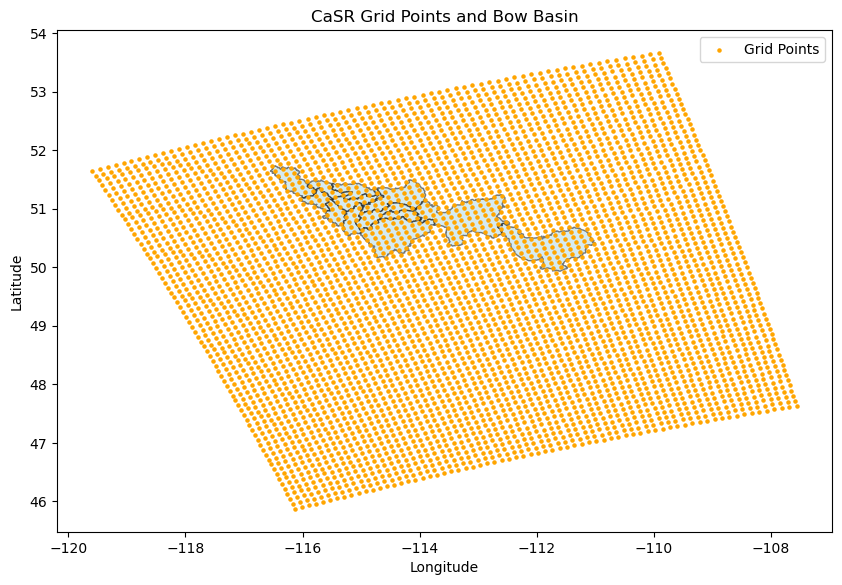

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
bow_basin.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5)
# Ensure grid points are in the correct CRS for plotting
# Convert longitude from 0-360 to -180 to 180 if needed
lon_plot = lon_flat.copy()
lon_plot[lon_plot > 180] -= 360

# Create new GeoSeries with adjusted longitude
points_plot = gpd.GeoSeries([Point(lon, lat) for lon, lat in zip(lon_plot, lat_flat)], crs=bow_basin.crs)

points_plot.plot(ax=ax, color='orange', markersize=5, label='Grid Points')
ax.set_title('CaSR Grid Points and Bow Basin')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.show()

In [14]:
# Extract grid points (lon_flat, lat_flat) that fall within the Bow basin shapefile

# Create a boolean mask for points within the basin
points_within_basin = points[mask]

# Extract the corresponding longitude and latitude values
lon_within_basin = lon_flat[mask.values]
lat_within_basin = lat_flat[mask.values]

# Create a DataFrame of selected points
selected_points_df = pd.DataFrame({
    'lon': lon_within_basin,
    'lat': lat_within_basin
})

# Display the DataFrame of points within the Bow basin
selected_points_df.head()

,lon,lat


## 1. FROSTBYTE gap filling

FROSTBYTE workflow  (In the original workflow, SCDNA precipitation data were also used to increase the data availability. However, here I'm only using CanSWE data because I couldn't find compatible precipitation dataset for the time period 1980-2024)

In [12]:
# Set user-specified variables
flag_buffer_default, buffer_km_default = 0, 0 # buffer flag (0: no buffer around test basin, 1: buffer of value buffer_default around test basin) and buffer default value in km to be applied if flag = 1
month_start_water_year_default, day_start_water_year_default = 10, 1  # water year start
month_end_water_year_default, day_end_water_year_default = 9, 30  # water year end
min_obs_corr_default = 3 # the minimum number of overlapping observations required to calculate the correlation between 2 stations
min_obs_cdf_default = 10 # the minimum number of observations required to calculate a station's cdf
min_corr_default = 0.6 # the minimum correlation value required for donor stations to be selected
window_days_default = 7 # the number of days used on either side of the infilling date for gap filling calculations
min_obs_KGE_default = 3 # the minimum number of observations required to calculate the KGE''
max_gap_days_default = 15  # max. number of days for gaps allowed in the daily SWE data for the linear interpolation
artificial_gap_perc_default = 100 # the percentage of observations to remove during the artificial gap filling for each station & month's first day
iterations_default = 1 # the number of times we repeat the artificial gap filling
artificial_gap_filling_flag = 0 # indicates whether artificial gap filling is performed (1) or not (0)
artificial_gap_filling_basins = ['all'] # a list of the basin(s) to run the gap filling for. To include all basins simply write 'all'

In [22]:
from snowdroughtindex.core.gap_filling import qm_gap_filling, artificial_gap_filling, plots_artificial_gap_evaluation

## 6. Summary

In this notebook, we've demonstrated the data preparation workflow for the Snow Drought Index package. We've loaded data, preprocessed it, extracted stations within the basin of interest, assessed data availability, and saved the processed data for use in subsequent analyses.

The workflow uses the following key functions from the `data_preparation` module:
- `load_swe_data()`, `load_precip_data()`, `load_basin_data()` for data loading
- `preprocess_swe()`, `preprocess_precip()` for data preprocessing
- `convert_to_geodataframe()` for converting data to GeoDataFrame
- `extract_stations_in_basin()` for extracting stations within a basin
- `filter_stations()` for filtering data by station
- `assess_data_availability()` for assessing data availability

These functions provide a standardized and reusable way to prepare data for the Snow Drought Index calculations.